In [1]:
!git clone https://github.com/zhongli1990/Covid19-X-Rays.git

Cloning into 'Covid19-X-Rays'...
remote: Enumerating objects: 239, done.
remote: Total 239 (delta 0), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (239/239), 74.15 MiB | 32.79 MiB/s, done.


In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
# import the necessary packages
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, models, layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [8]:
!ls

Covid19-X-Rays	sample_data


In [9]:
# set learning rate, epochs and batch size
INIT_LR = 1e-5    # This value is specific to what model is chosen: Inception, VGG or ResnNet.
EPOCHS = 50 
BS = 8

print("Loading images...")
imagePath = "./Covid19-X-Rays/all/train"
imagePaths = list(paths.list_images(imagePath))

data = []
labels = []

# read all X-Rays in the specified path, and resize them all to 256x256
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    data.append(image)
    labels.append(label)
    
#normalise pixel values to real numbers between 0.0 - 1.0 
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding for a 3-class labeling 
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
labels = to_categorical(integer_encoded)

print("... ... ", len(data), "images loaded in 3x classes:")
print(label_encoder.classes_)

Loading images...
... ...  200 images loaded in 3x classes:
['covid' 'normal' 'pneumonia_bac']


In [10]:
# split the data between train and validation.
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

# add on a simple Augmentation. Note: too many Augumentation doesn't actually help in this case - I found during the test. 
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

#Use the InveptionV3 model with Transfer Learning of pre-trained "ImageNet"'s weights.
#note: If you choose VGG16 or ResNet you may need to reset the initial learning rate at the top.
baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))
#baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))
#baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

#Add on a couple of custom CNN layers on top of the Inception V3 model. 
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# Compose the final model
model = Model(inputs=baseModel.input, outputs=headModel)

# Unfreeze pre-trained Inception "ImageNet" weights for re-training since I got a Navidia T5 GPU to play with anyway

#for layer in baseModel.layers:
#    layer.trainable = False

print("Compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("Training the full stack model...")
H = model.fit_generator( trainAug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS,
                         validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

87916544/87910968 [==============================] - 1s 0us/step
Compiling model...
Training the full stack model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
20/20 [==============================] - 113s 5s/step - loss: 1.3433 - accuracy: 0.3624 - val_loss: 1.4715 - val_accuracy: 0.3500
Epoch 2/50
20/20 [==============================] - 104s 5s/step - loss: 1.0810 - accuracy: 0.4767 - val_loss: 1.2711 - val_accuracy: 0.4250
Epoch 3/50
20/20 [==============================] - 104s 5s/step - loss: 0.9082 - accuracy: 0.6180 - val_loss: 1.0924 - val_accuracy: 0.5000
Epoch 4/50
20/20 [==============================] - 107s 5s/step - loss: 0.8687 - accuracy: 0.6266 - val_loss: 1.0187 - val_accuracy: 0.5000
Epoch 5/50
20/20 [==============================] - 104s 5s/step - loss: 0.8527 - accuracy: 0.5767 - val_loss: 0.9833 - val_accuracy: 0.4500
Epoch 6/50
20/20 [==============================] - 105s 5s/step - loss: 0.7631 - accuracy: 0.6822 - val_loss: 0.9367 - val_accuracy: 0.4750
Epoch 7/50
20/20 [==============================] - 105s 5s/step - loss: 0.7564 - accuracy: 0.6498 - val_loss: 0.8640 - val_accuracy: 0.5500
Epoch 8/50
20

Evaluating the trained model ...
               precision    recall  f1-score   support

        covid       0.92      0.92      0.92        12
       normal       1.00      0.93      0.96        14
pneumonia_bac       0.93      1.00      0.97        14

     accuracy                           0.95        40
    macro avg       0.95      0.95      0.95        40
 weighted avg       0.95      0.95      0.95        40

[[11  0  1]
 [ 1 13  0]
 [ 0  0 14]]
acc: 0.9500
sensitivity: 0.9167
specificity: 0.9643


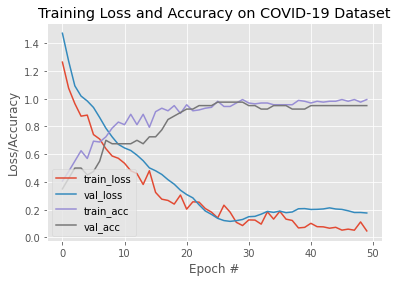

In [15]:
print("Evaluating the trained model ...")
preds = model.predict(testX, batch_size=BS)

preds = np.argmax(preds, axis=1)

print(classification_report(testY.argmax(axis=1), preds, target_names=label_encoder.classes_))

# calculate a basic confusion matrix 
cm = confusion_matrix(testY.argmax(axis=1), preds)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
specificity = (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]) / (cm[1, 0] + cm[1, 1] + cm[1, 2] + cm[2, 0] + cm[2, 1] + cm[2, 2])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS 
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("./Covid19-X-Rays/all/s-class-plot.png")

In [16]:
print("[INFO] loading untrained test images...")
imagePathTest = "./Covid19-X-Rays/all/test"
imagePathsTest = list(paths.list_images(imagePathTest))
print(len(imagePathsTest))

dataTest = []
labelsTest = []

# loop over the image paths
for imagePathTest in imagePathsTest:

    # extract the class label from the filename
	  labelTest = imagePathTest.split(os.path.sep)[-2]
  
	  # load the image, swap color channels, and resize it to be a fixed
	  # 256x256 pixels while ignoring aspect ratio
	  imageTest = cv2.imread(imagePathTest)
	  imageTest = cv2.cvtColor(imageTest, cv2.COLOR_BGR2RGB)
	  imageTest = cv2.resize(imageTest, (256, 256))

	  # update the data and labels lists, respectively
	  dataTest.append(imageTest)
	  labelsTest.append(labelTest)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
dataTest = np.array(dataTest) / 255.0
labelsTest = np.array(labelsTest)


# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labelsTest)
labelsTest = to_categorical(integer_encoded)

print(labelsTest)

[INFO] loading untrained test images...
27
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [17]:
predTest = model.predict(dataTest, batch_size=BS)

print(predTest)

[[9.82677519e-01 9.48007777e-03 7.84236286e-03]
 [9.97663498e-01 8.17398395e-05 2.25485489e-03]
 [9.69811976e-01 1.82313398e-02 1.19567262e-02]
 [9.96514261e-01 3.94023402e-04 3.09173414e-03]
 [9.98731673e-01 1.97097223e-04 1.07124506e-03]
 [9.96029913e-01 1.39301328e-03 2.57700100e-03]
 [7.11825728e-01 1.22145124e-01 1.66029125e-01]
 [9.97190177e-01 4.00149729e-04 2.40968401e-03]
 [9.99718130e-01 2.17644010e-05 2.60061235e-04]
 [2.48700875e-04 7.61280127e-04 9.98989999e-01]
 [4.56883386e-02 4.83945906e-02 9.05917048e-01]
 [8.99402983e-03 1.41898450e-02 9.76816177e-01]
 [1.94640961e-02 1.61538720e-02 9.64382052e-01]
 [1.22757005e-02 9.92585090e-04 9.86731708e-01]
 [1.37373703e-02 3.34288948e-03 9.82919812e-01]
 [5.98503568e-04 1.97675684e-03 9.97424722e-01]
 [1.93912238e-02 7.34558403e-02 9.07152891e-01]
 [1.80802788e-04 3.66194989e-04 9.99453008e-01]
 [4.95449858e-05 9.99464691e-01 4.85717785e-04]
 [5.00741974e-03 9.86596525e-01 8.39609280e-03]
 [4.42734599e-04 9.97432530e-01 2.124817

In [18]:
predClasses = predTest.argmax(axis=-1)
print(predClasses)

[0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1]


In [19]:
# make predictions on the testing set
print("Evaluating real test samples ...")

testX = dataTest
testY = labelsTest

predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=label_encoder.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
specificity = (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]) / (cm[1, 0] + cm[1, 1] + cm[1, 2] + cm[2, 0] + cm[2, 1] + cm[2, 2])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Evaluating real test samples ...
               precision    recall  f1-score   support

        covid       1.00      1.00      1.00         9
       normal       1.00      1.00      1.00         9
pneumonia_bac       1.00      1.00      1.00         9

     accuracy                           1.00        27
    macro avg       1.00      1.00      1.00        27
 weighted avg       1.00      1.00      1.00        27

[[9 0 0]
 [0 9 0]
 [0 0 9]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [20]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import imutils
import matplotlib.pyplot as plt
import cv2

In [21]:
new_model = model #tf.keras.models.load_model('saved_model/inceptionV3')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
with tf.GradientTape() as tape:
 last_conv_layer = model.get_layer('mixed10') 
 iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
 model_out, last_conv_layer = iterate(testX)
 class_out = model_out[:, np.argmax(model_out[0])]
 grads = tape.gradient(class_out, last_conv_layer)
 pooled_grads = K.mean(grads, axis=(0, 1, 2))
 heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

In [25]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
        self.layerName = self.find_target_layer()
    
  def find_target_layer(self):
    for layer in reversed(self.model.layers):
        # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
            return layer.name
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
        inputs=[self.model.inputs],
        outputs=[self.model.get_layer(self.layerName).output,
            self.model.output])
    # record operations for automatic differentiation

    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, self.classIdx]

    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    
    # resize the heatmap to oringnal X-Ray image size
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    
    # normalize the heatmap
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    
    # return the resulting heatmap to the calling function
    return heatmap

In [36]:
 def results(filename, new_model):
  
  original = cv2.imread(filename)
  plt.imshow(original)
  plt.show()

  orig = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
  resized = cv2.resize(orig, (256, 256))
  dataXG = np.array(resized) / 255.0
  dataXG = np.expand_dims(dataXG, axis=0)

  preds = new_model.predict(dataXG)
  i = np.argmax(preds[0])
  print(i, preds)

  cam = GradCAM(model=new_model, classIdx=i, layerName='mixed10') # find the last 4d shape "mixed10" in this case
  heatmap = cam.compute_heatmap(dataXG)#show the calculated heatmap
  plt.imshow(heatmap)
  plt.show()

  heatmapY = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
  heatmapY = cv2.applyColorMap(heatmapY, cv2.COLORMAP_HOT)  # COLORMAP_JET, COLORMAP_VIRIDIS, COLORMAP_HOT
  imageY = cv2.addWeighted(heatmapY, 0.5, original, 1.0, 0)
  print(heatmapY.shape, orig.shape)# draw the orignal x-ray, the heatmap, and the overlay together
  output = np.hstack([orig, heatmapY, imageY])
  fig, ax = plt.subplots(figsize=(20, 18))
  ax.imshow(np.random.rand(1, 99), interpolation='nearest')
  plt.imshow(output)
  plt.show()

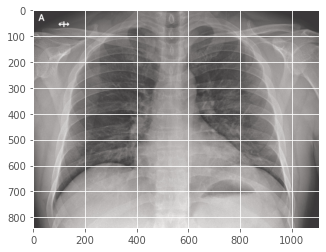

0 [[0.9960299  0.00139301 0.002577  ]]


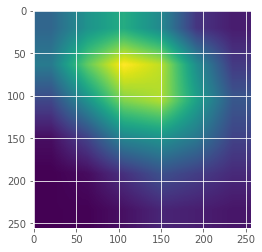

(841, 1107, 3) (841, 1107, 3)


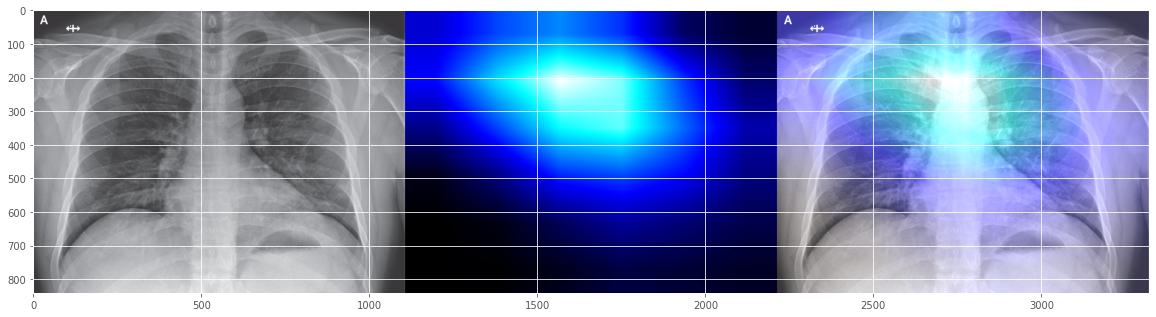

In [37]:
filename = "./Covid19-X-Rays/all/test/covid/nejmoa2001191_f5-PA.jpeg"
results(filename, new_model)

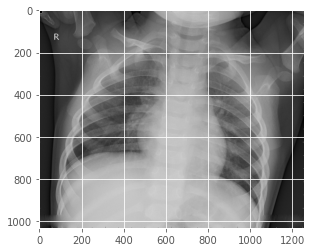

1 [[0.00522749 0.8035709  0.19120157]]


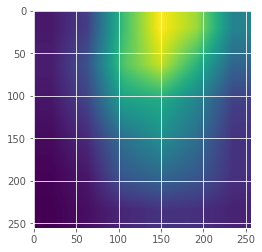

(1032, 1256, 3) (1032, 1256, 3)


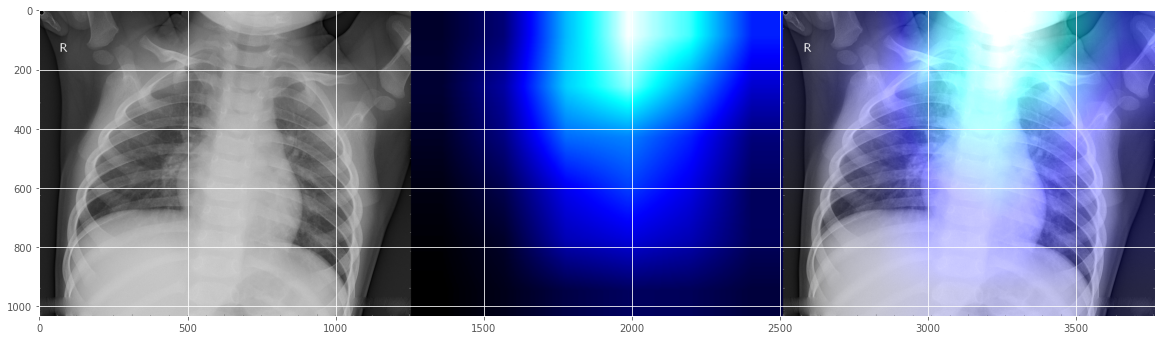

In [38]:
filename = "./Covid19-X-Rays/all/test/normal/NORMAL2-IM-1396-0001.jpeg"
results(filename, new_model)

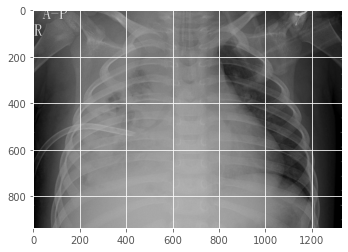

2 [[0.00899404 0.01418984 0.9768162 ]]


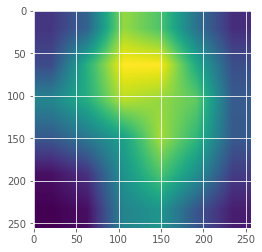

(936, 1328, 3) (936, 1328, 3)


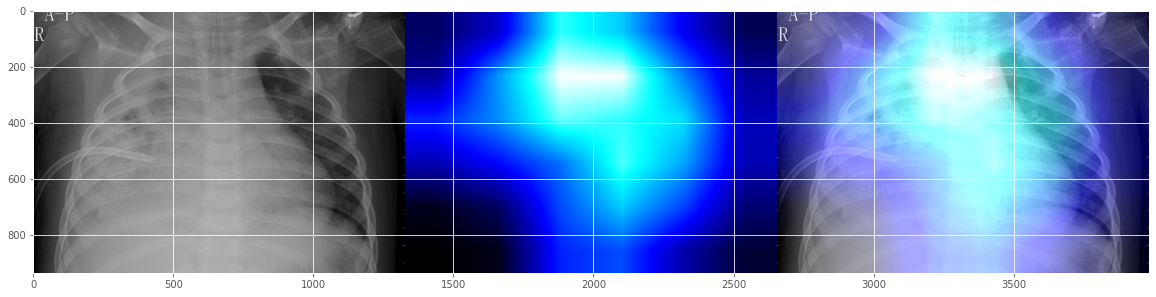

In [39]:
filename = "./Covid19-X-Rays/all/test/pneumonia_bac/person1940_bacteria_4859.jpeg"
results(filename, new_model)